<a href="https://colab.research.google.com/github/iwatobipen/playground/blob/master/visualize_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2018-11-07 13:42:36--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.16.19.10, 104.16.18.10, 2606:4700::6810:130a, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.16.19.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62574861 (60M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  59.68M   104MB/s    in 0.6s    

2018-11-07 13:42:41 (104 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [62574861/62574861]

PREFIX=/usr/local
reinstalling: python-3.7.0-hc3d631a_0 ...
Python 3.7.0
reinstalling: ca-certificates-2018.03.07-0 ...
reinstalling: conda-env-2.6.0-1 ...
reinstalling: libgcc-ng-8.2.0-hdf63c60_1 ...
reinstalling: libstdcxx-ng-8.2.0-hdf63c60_1 ...
reinstalling: libffi-3.2.1-hd88cf55_4 ...
reinstalling: ncurses-6.1-hf484d3e_0 ...
reinstalling: openssl-1.0.2p-h14c3975_0 ...
reinstalling: xz-5.2.4-h14

In [2]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
print(rdBase.rdkitVersion)

2018.09.1


In [0]:
trainpath = os.path.join(RDConfig.RDDocsDir, 'Book/data/solubility.train.sdf')
testpath = os.path.join(RDConfig.RDDocsDir, 'Book/data/solubility.test.sdf')
solclass = {'(A) low':0, '(B) medium': 1, '(C) high': 2}
n_splits = 10

In [0]:
def mol2fp(mol,nBits=1024):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr, bitInfo

In [0]:
trainmols = [m for m in Chem.SDMolSupplier(trainpath)]
testmols = [m for m in Chem.SDMolSupplier(testpath)]

In [0]:
trainX = np.array([mol2fp(m)[0] for m in trainmols])
trainY = np.array([solclass[m.GetProp('SOL_classification')] for m in trainmols], dtype=np.int)

testX = np.array([mol2fp(m)[0] for m in testmols])
testY = np.array([solclass[m.GetProp('SOL_classification')] for m in testmols], dtype=np.int)

In [7]:
rfclf = RandomForestClassifier(n_estimators=50)
skf = StratifiedKFold(n_splits=n_splits)
for train, test in skf.split(trainX, trainY):
    trainx = trainX[train]
    trainy = trainY[train]
    testx = trainX[test]
    testy = trainY[test]
    rfclf.fit(trainx, trainy)
    predy = rfclf.predict(testx)
    print(accuracy_score(testy, predy))

0.40384615384615385
0.4807692307692308
0.6213592233009708
0.6213592233009708
0.6116504854368932
0.6213592233009708
0.5784313725490197
0.6039603960396039
0.5346534653465347
0.5742574257425742


In [0]:
fimportance = rfclf.feature_importances_
fimportance_dict = dict(zip(range(1024), fimportance))
sorteddata = sorted(fimportance_dict.items(), key=lambda x:-x[1])
top50feat = [x[0] for x in sorteddata][:50]

In [0]:
solblemol_idx = []
for i, v in enumerate(testY):
    if v == 2:
        solblemol_idx.append(i)

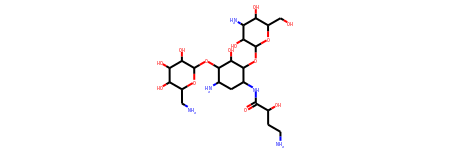

In [10]:
testidx = solblemol_idx[-1] 
testmols[testidx]

In [11]:
rfclf.predict([testX[testidx]])

array([2])

In [0]:
fp, bitinfo = mol2fp(testmols[testidx])

In [0]:
onbit = [bit for bit in bitinfo.keys()]
importantonbits = list(set(onbit) & set(top50feat))

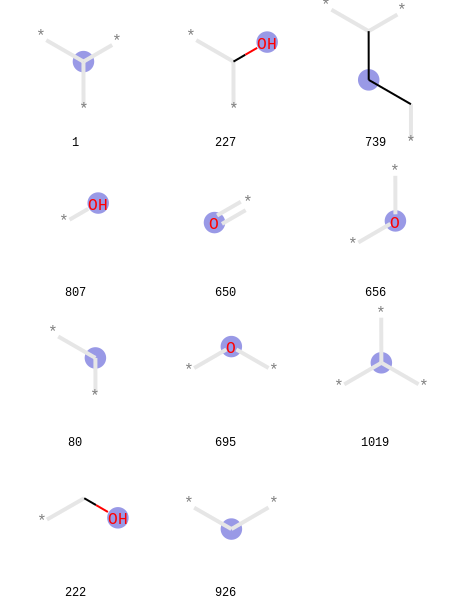

In [14]:
tpls = [(testmols[testidx], x, bitinfo) for x in importantonbits]
Draw.DrawMorganBits(tpls, legends = [str(x) for x in importantonbits])